# Projet Python pour le Data Scientist 

Projet réalisé par Eric Vong, Thibaut Valour et Solène Blasco Lopez

Ce projet Python utilise les données de l'OpenData de Paris sur l'encadrement des loyers de 2019, enrichies par l'intermédiaire de données web-scrapées sur internet. Il expérimente différents modèles de régression entrainés sur ces données dans le but de prédire les loyers de référence des appartements parisiens. L'objet de ce projet est donc de répondre à la problématique suivante : Quels sont les déterminants du loyer d'un bien immobilier parisien ?

In [34]:
import re

# Manipulation des donneés :
import pandas as pd
import geopandas as gpd

# Web-scraping :
import urllib
import bs4 

# Représentations graphiques :
import matplotlib.pyplot as plt

## Partie 1 - récupération et traitement des données
*Les lignes de code qui suivent peuvent être trouvées dans le dossier `data` du dépôt git*

### 1. Récupération des données de la mairie de Paris concernant l'encadrement des loyers

La mairie de Paris a mis en ligne une base de données concernant l'encadrement des loyers de ses logements en 2019. On y trouve une classification des logements, selon leur secteur de localisation (quartier administratif) et leur type (nombre de pièces, époque de construction, meublé/non-meublé), accompagnée de leurs loyers de référence. 

*Lien contenant les informations sur ces données : https://opendata.paris.fr/explore/dataset/logement-encadrement-des-loyers/information/?disjunctive.id_zone&disjunctive.nom_quartier&disjunctive.piece&disjunctive.epoque&disjunctive.meuble_txt&sort=-id_zone&location=15,48.84958,2.34691&basemap=jawg.streets*

In [2]:
donnees_brutes = gpd.read_file('https://opendata.paris.fr/explore/dataset/logement-encadrement-des-loyers/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

On ne sélectionne que les colonnes qui nous intérèssent : 
- `nom_quartier` et `id_quartier` : nom et id du quartier (administratif)
- `ref` : loyer de référence (encadrement : `min` et `max`)
- `epoque` : époque de construction de l'appartement
- `meuble_txt` : location en tant que logement meublé ou non-meublé
- `piece` : nombre de pièces
- `geometry` : représentation graphique du quartier.

In [3]:
donnees = donnees_brutes[['nom_quartier','id_quartier','ref','min','max','epoque','meuble_txt','piece','geometry']]

In [4]:
donnees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry
0,Amérique,75,14.6,10.22,17.52,1946-1970,non meublé,4,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ..."
1,Pont-de-Flandre,74,18.5,12.95,22.20,Apres 1990,meublé,4,"POLYGON ((2.38488 48.88663, 2.38483 48.88662, ..."
2,Belleville,77,23.4,16.38,28.08,1971-1990,meublé,4,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ..."
3,Amérique,75,21.2,14.84,25.44,1971-1990,non meublé,1,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ..."
4,Amérique,75,18.5,12.95,22.20,Apres 1990,meublé,4,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ..."


Cette base de données référence 2560 appartements. On vérifie qu'il n'y a pas de valeurs manquantes :

In [5]:
donnees.count()

nom_quartier    2560
id_quartier     2560
ref             2560
min             2560
max             2560
epoque          2560
meuble_txt      2560
piece           2560
geometry        2560
dtype: int64

### 2. Création de deux variables : superficie des quartiers et leur distance au centre de Paris


In [6]:
donnees.crs

{'init': 'epsg:4326'}

On va devoir faire en sorte d'utiliser le système de projection `epsg 2154` dans la suite pour pouvoir obtenir des distances en mètres et des aires en mètres carrés.

- On ajoute la distance du centre de chaque quartier au centre de Paris dans la variable `distance_centre_paris` (intuition : plus un bien est proche du centre de Paris, plus il est convoité et donc valorisé) :

In [7]:
#Centres des quartiers :

df = donnees.centroid 
df = df.to_crs(epsg=2154)

In [8]:
#Centre de Paris (coordonnées trouvées sur internet): 

longitude = [2.3488 for i in range(2560)]
latitude = [48.8534 for i in range(2560)]

df2 = gpd.GeoDataFrame(geometry = gpd.points_from_xy(longitude, latitude),crs={'init': 'epsg:4326'})
df2 = df2.to_crs(epsg=2154)

In [9]:
# Tables des distances pour chaque appartement de la base de données :

distances = pd.DataFrame(df.distance(df2)*10**(-3),columns=["distance_centre_paris"])  #la multiplication par 10^3 convertit les mètres en kms

In [11]:
# Ajout de la nouvelle variable à la base de données : 

donnees = donnees.join(distances)

In [13]:
donnees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry,distance_centre_paris
0,Amérique,75,14.6,10.22,17.52,1946-1970,non meublé,4,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",4.643892
1,Pont-de-Flandre,74,18.5,12.95,22.20,Apres 1990,meublé,4,"POLYGON ((2.38488 48.88663, 2.38483 48.88662, ...",5.379327
2,Belleville,77,23.4,16.38,28.08,1971-1990,meublé,4,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ...",3.485188
3,Amérique,75,21.2,14.84,25.44,1971-1990,non meublé,1,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",4.643892
4,Amérique,75,18.5,12.95,22.20,Apres 1990,meublé,4,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",4.643892


- On ajoute également la superficie de chaque quartier dans la variable `superficie_quartier` (intuition : plus un quartier est petit plus l'offre de logements est restreinte et les biens sont valorisés) :

In [14]:
# On ne conserve que les géométries, pour les passer dans le système espg 2154 :
df3 = donnees.geometry
df3 = df3.to_crs(epsg=2154)

In [15]:
#Création de la nouvelle variable :
donnees['superficie_quartier'] = df3.area.div(10**6)  #La division convertit les m² en km²

In [16]:
donnees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry,distance_centre_paris,superficie_quartier
0,Amérique,75,14.6,10.22,17.52,1946-1970,non meublé,4,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",4.643892,1.835720
1,Pont-de-Flandre,74,18.5,12.95,22.20,Apres 1990,meublé,4,"POLYGON ((2.38488 48.88663, 2.38483 48.88662, ...",5.379327,2.376238
2,Belleville,77,23.4,16.38,28.08,1971-1990,meublé,4,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ...",3.485188,0.806569
3,Amérique,75,21.2,14.84,25.44,1971-1990,non meublé,1,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",4.643892,1.835720
4,Amérique,75,18.5,12.95,22.20,Apres 1990,meublé,4,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",4.643892,1.835720


### 3. Enrichissement des données : création d'un score lié aux stations de métro et de rer des quartiers

Pour enrichir ces données et mieux comprendre l'effet du quartier sur le loyer d'un logement, on ajoute une variable `score_metro` calculée de la manière suivante :
   - on liste les lignes distinctes de métro et de rer qui passent dans chaque quartier
   - on attribue un score à chaque ligne, qui correspond à sa fréquentation annuelle 
   - on somme pour chaque quartier les scores de ses lignes de métro/rer
   - Le score d'un quartier correspond alors à cette somme, divisée par la plus grande valeur attribuée à un quartier

De cette manière, on obtient un score compris entre 0 et 1 pour chaque quartier.    

Pour créer ce score, on récupère la liste des stations de métro et de rer de Paris, ainsi que leurs positions géographiques et leurs lignes desservies. Ces données sont récupérées sur Wikipédia par web-scraping. Pour chaque station, on récupère son nom et on se rend sur sa page Wikipédia pour récupérer ses coordonnées géographiques. Cette station est dupliquée pour chaque ligne de métro qu'elle dessert. 

*Les liens utilisés sont les suivants :*
- *Pour le métro : https://fr.wikipedia.org/wiki/Liste_des_stations_du_m%C3%A9tro_de_Paris*
- *Pour le rer : https://fr.wikipedia.org/wiki/Liste_des_gares_du_RER_d%27%C3%8Ele-de-France*

In [17]:
# Fonction pour transformer les coordonnées récoltées (sous format DMS nord-est) en format DD :

dd = lambda d,m,s : float(d) + float(m)/60 + float(s)/(60*60)
def dms_to_dd (dms):
    parts = re.split('[^\d\w]+', dms)
    lat = dd(parts[0], parts[1], parts[2])
    lng = dd(parts[4], parts[5], parts[6])
    return (lat, lng)

In [18]:
#Création de la base de données des stations de métro et de rer par web scraping : 

nom = []
ligne = [] 
latitude = []
longitude = []

urls = ['https://fr.wikipedia.org/wiki/Liste_des_stations_du_m%C3%A9tro_de_Paris','https://fr.wikipedia.org/wiki/Liste_des_gares_du_RER_d%27%C3%8Ele-de-France']

for url in urls : 

    sock = urllib.request.urlopen(url).read() 
    page=bs4.BeautifulSoup(sock)

    liste_stations = page.find('table').findAll('tr')
    
    for station in liste_stations[1:] :
    
        #Nom de la station :    
        nom_station = station.find('a').text
    
        #Coordonnées géographiques de la station :
        url_station = "http://fr.wikipedia.org"+station.find('a').get('href')
    
        search = urllib.request.urlopen(url_station).read()
        search_station=bs4.BeautifulSoup(search)
    
        coord = search_station.find('a',{'class': "mw-kartographer-maplink"}).text
        lat,lng = dms_to_dd(coord)
    
        #Lignes desservies par la station :    
        lignes = station.find('span',{'style' : "white-space:nowrap"}).findAll('span')
    
        for l in lignes : 
            nom.append(nom_station)
            ligne.append(l.get('data-sort-value'))
            latitude.append(lat)
            longitude.append(lng)
            
stations = gpd.GeoDataFrame(pd.DataFrame({'nom' : nom, 'ligne' : ligne}),geometry=gpd.points_from_xy(longitude, latitude))

In [19]:
stations.head(5)

,nom,ligne,geometry
0,Abbesses,12 !,POINT (2.33861 48.88444)
1,Alésia,04 !,POINT (2.32667 48.82833)
2,Alexandre Dumas,02 !,POINT (2.39500 48.85611)
3,Alma - Marceau,09 !,POINT (2.30028 48.86500)
4,Anatole France,03 !,POINT (2.28556 48.89194)


On récupère ensuite une base de données de la mairie de Paris contenant la liste de ses quartiers administratifs et leur représentation graphique :

In [20]:
quartiers_bruts = gpd.read_file('https://parisdata.opendatasoft.com/explore/dataset/quartier_paris/download/?format=geojson&timezone=Europe/Berlin&lang=fr')
quartiers = quartiers_bruts[['l_qu','c_qu','geometry']]  #l_qu : nom du quartier ; c_qu : numéro du quartier

In [21]:
quartiers.head(5)

,l_qu,c_qu,geometry
0,Sainte-Avoie,12,"POLYGON ((2.35822 48.86122, 2.35690 48.86007, ..."
1,Hôpital-Saint-Louis,40,"POLYGON ((2.37243 48.87611, 2.37359 48.87509, ..."
2,Belleville,77,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ..."
3,Ternes,65,"POLYGON ((2.29504 48.87378, 2.29504 48.87378, ..."
4,Folie-Méricourt,41,"POLYGON ((2.37010 48.86376, 2.36690 48.86246, ..."


On associe ensuite à chaque station le quartier auquel elle appartient :

In [22]:
stations_quartiers = gpd.sjoin(stations, quartiers, op='intersects')


C:\Users\blasc\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:58: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  warn(


Il ne reste plus qu'à supprimer les doublons pour savoir quelles lignes de métro ou rer passent dans chaque quartier de Paris. 

In [23]:
lignes_quartiers = stations_quartiers[['c_qu','ligne']].drop_duplicates()

In [24]:
lignes_quartiers.tail(5)

,c_qu,ligne
346,11,08 !
349,7,03 !
361,15,07 !
369,4,01 !
453,19,B !


Ensuite, on réalise un nouveau web scraping sur Wikipédia pour attribuer un score à chaque ligne : on va lister chaque ligne et sa fréquentation annuelle, divisée par la fréquentation annuelle la plus élevée.

In [25]:
#Pour le rer, il faut aller sur chaque page Wikipédia de la ligne. Pour aller plus vite, on le fait manuellement (il n'y a que 5 lignes) :

lignes = ['A !','B !','C !','D !','E !']
frequentation = [309.36,165.5,140,145,60] 


#Pour le métro, il existe directement un classement sur Wikipédia :

sock = urllib.request.urlopen("https://fr.wikipedia.org/wiki/Liste_des_lignes_de_m%C3%A9tro_parisiennes_par_fr%C3%A9quentation").read() 
page=bs4.BeautifulSoup(sock)

liste_lignes = page.find('table').findAll('tr')

for ligne in liste_lignes[1:] :
    
    freq = ligne.find('bdi')
    
    for sous_ligne in ligne.findAll('span') :
        lignes.append(sous_ligne.get('data-sort-value'))
        frequentation.append(float(freq.text.replace(',','.')))
        
lignes_freq = pd.DataFrame({'ligne' : lignes,'fréquentation' : frequentation})

In [27]:
lignes_freq.head(5)

,ligne,fréquentation
0,A !,309.36
1,B !,165.50
2,C !,140.00
3,D !,145.00
4,E !,60.00


In [28]:
# Ajout du score des lignes pour chaque quartier : 

lignes_quartiers_freq = lignes_quartiers.merge(lignes_freq, on='ligne')

In [29]:
#Création du score des quartiers : 

quartiers_freq = lignes_quartiers_freq[['c_qu','fréquentation']].groupby('c_qu').sum()

m = max(quartiers_freq['fréquentation'])

quartiers_freq['fréquentation'] = quartiers_freq['fréquentation']/m

Pour finir, on ajoute le score obtenu à notre base de données :

In [30]:
donnees_augmentees = donnees.join(quartiers_freq, on='id_quartier')
donnees_augmentees.rename(columns={'fréquentation': 'score_metro'}, inplace=True)

In [31]:
donnees_augmentees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry,distance_centre_paris,superficie_quartier,score_metro
0,Amérique,75,14.6,10.22,17.52,1946-1970,non meublé,4,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",4.643892,1.835720,0.369742
1,Pont-de-Flandre,74,18.5,12.95,22.20,Apres 1990,meublé,4,"POLYGON ((2.38488 48.88663, 2.38483 48.88662, ...",5.379327,2.376238,0.298062
2,Belleville,77,23.4,16.38,28.08,1971-1990,meublé,4,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ...",3.485188,0.806569,0.038651
3,Amérique,75,21.2,14.84,25.44,1971-1990,non meublé,1,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",4.643892,1.835720,0.369742
4,Amérique,75,18.5,12.95,22.20,Apres 1990,meublé,4,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",4.643892,1.835720,0.369742


### Eventuelles limites de ce score : 

On a ici créer par nous mêmes un score pour chaque quartier, d'autant plus élévé que les lignes de métro et rer qui passent dans un quartier sont nombreuses et importantes en termes de fréquentation.

Cependant, il convient de noter les éventuelles limites de ce score : 
- on ne prend pas en compte les stations de vélib et autres transports
- les quartiers ont des tailles très diverses : les grands quartiers aux extrémités ouest et est de Paris ne sont donc pas forcément très bien représentés en termes de transports via seulement le métro et le rer. On constate sur le graphique suivant qu'une majorité de la superficie de ces quartiers n'est pas désservie par le métro ou le rer.
- on ne regarde ici que les lignes qui passent dans un quartier. Mais, pour les petits quartiers du centre de Paris par exemple, il est très facile d'accéder sans trop de temps aux stations des quartiers voisins. Pour les plus grand quartiers, si l'on habite proche des frontières on peut par exemple préférer les stations du quartier d'à côté, plus proches, que les stations à l'autre bout de son propre quartier. 

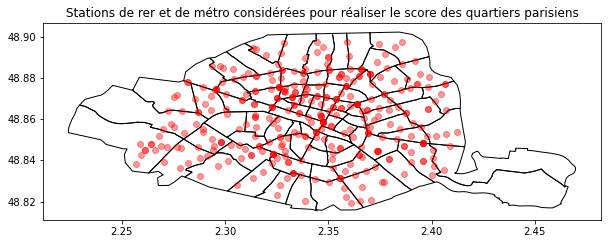

In [36]:
axi = stations_quartiers.plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
quartiers.plot(ax = axi, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
plt.title("Stations de rer et de métro considérées pour réaliser le score des quartiers parisiens")
plt.show()

## Partie 2 - Analyse descriptive et représentation graphique
*Les lignes de code qui suivent peuvent être trouvées dans le dossier `...` du dépôt git*